In [29]:
"""
Patrick Brosseau 2023/01/20

Artificial neural network (ANN) is used to determine the ideal amplitude mask for a given pulse spectrum and a desired pulse 
spectrum. Meant to simulate the operation of an acousto-optic programmable dispersive filter (AOPDF), such as the Dazzler by Fastlite.

The AOPDF is a literal black box which shapes the spectral amplitude and phase of a light pulse as a laser beam is transmitted
through the box. The AOPDF software accepts a 1D amplitude mask, generates an acoustic wave corresponding to this amplitude mask,
and shape the pulse amplitude through interaction between the generated acoustic wave and the optical beam.

Generally, one desires the pulse spectrum to have a specific shape, such as a super-Gaussian. One would therefore 1) measure the
pulse spectrum without an amplitude mask applied by the AOPDF, 2) calculate a mask by dividing the desired spectrum by the 
current spectrum and 3) measure the pulse spectrum with the amplitude mask to confirm that the masked spectrum resembles the
desired spectrum.

This task is complicated by several factors, as the ideal amplitude mask is not exactly equal to the desired spectrum divided by
the un-masked spectrum. First, the AOPDF masks the amplitude rather than the intensity, so the square root of the measured 
spectrum must be used. Secondly, there is generally a slight calibration off-set between the AOPDF wavelength vector and the
spectrometer wavelength vector, requiring that the mask is shifted or re-scaled. Thirdly, both the spectrometer and AOPDF can
have non-linear responses. These three factors make determination of the ideal mask vector a non-trivial task, and the calculated
mask vector generally differs from the ideal mask vector by some small amount, which could be enough to drastically change the
shape of the masked pulse spectrum.

The ANN is used to characterize the AOPDF transfer function. The measured spectrum has length n. The ANN accepts a 1D vector, 
consisting of the measured spectrum concatenated with the desired spectrum, with length 2n. The ANN outputs a 1D vector, 
corresponding to the amplitude mask, of length n.

"""


import numpy as np
from numpy import mean
from numpy import std
from numpy.random import random
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter,gaussian_filter1d
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

from tqdm import tqdm
import glob


def super_gaus(x,a,x0,sigma,order):
    return a*np.exp(-((x-x0)**2/(2*sigma**2))**order)

# Load data

Text(0.5, 1.0, 'Loaded,simulated spectra')

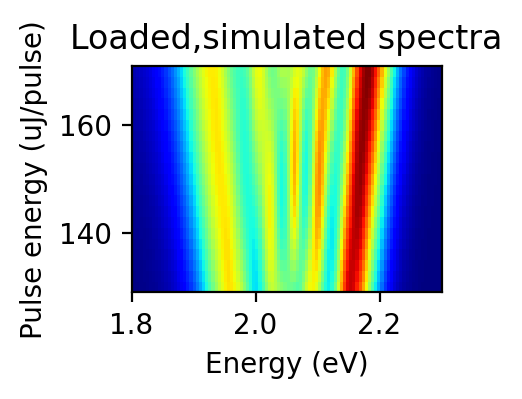

In [30]:
"""
Input data simulated using split-step Fourier method (SSFM) for a range of pulse energies, from 130 to 170 uJ per pulse.
"""

dat = np.load(r"C:\Users\patri\Documents\LAB\FROG\deepfrog\fiber_spectrum_130to170.npz")
spectrum_mat_load = dat['spectrum_mat_load']
ev = dat['ev']
powers = dat['powers']

plt.figure(figsize=(2,1.5),dpi=200)
plt.pcolormesh(ev,powers,spectrum_mat_load,cmap="jet")
plt.xlim(1.8,2.3)
plt.xlabel("Energy (eV)")
plt.ylabel("Pulse energy (uJ/pulse)")
plt.title("Loaded,simulated spectra")

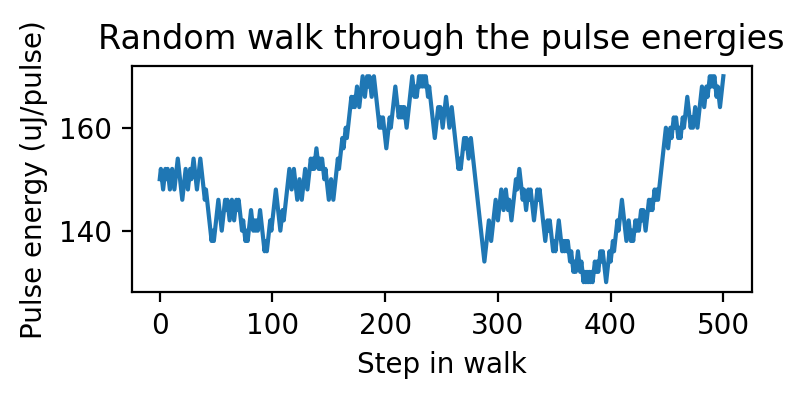

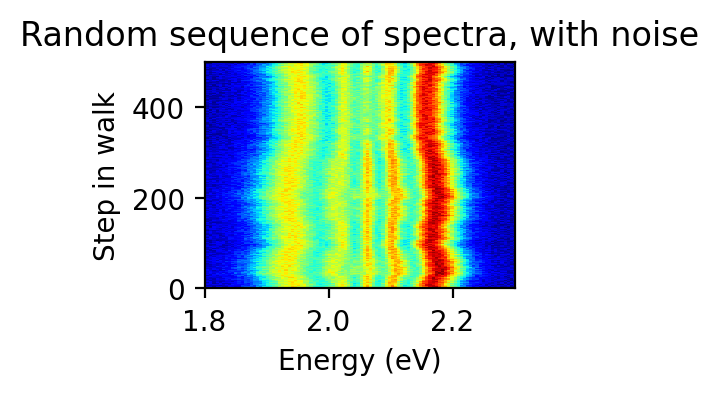

In [31]:
"""
The noisy and drifting laser spectrum is simulated by taking a random walk through the simulate pulse spectra.
"""

def Randomwalk1D(n): #n here is the no. of steps that we require
    x = 10
    xposition = [10] #starting from origin (0,0)
    for i in range (1,n+1):
        if xposition[-1] == 20:
            x-=1
        elif xposition[-1] == 0:
            x+=1
        else:            
            step = np.random.uniform(0,1)
            if step < 0.5: # if step is less than 0.5 we move up    
                x -= 1
            if step > 0.5: # if step is greater than 0.5 we move down  
                x += 1
        xposition.append(x)
    return xposition

exp_len = 500 #Steps in the random walk
walk = Randomwalk1D(exp_len)

plt.figure(figsize=(4,1.5),dpi=200)
plt.plot(powers[walk])
plt.xlabel("Step in walk")
plt.ylabel("Pulse energy (uJ/pulse)")
plt.title("Random walk through the pulse energies")

spectrum_mat_random = []
walk = Randomwalk1D(exp_len)
for i in range(0,exp_len):
    spectrum_mat_random.append(spectrum_mat_load[walk[i],:])
spectrum_mat_random = np.array(spectrum_mat_random)

#Add noise to spectrum after random walk
noise = 0.1*random((spectrum_mat_random.shape))
spectrum_mat_random = spectrum_mat_random + noise

plt.figure(figsize=(2,1.5),dpi=200)
plt.pcolormesh(ev,np.linspace(0,exp_len,exp_len),spectrum_mat_random,cmap="jet")
plt.xlim(1.8,2.3)
plt.xlabel("Energy (eV)")
plt.ylabel("Step in walk")
plt.title("Random sequence of spectra, with noise")

spec_num = exp_len
spectrum_mat= spectrum_mat_random



spectrum_mat_test_random = []
walk = Randomwalk1D(exp_len)
for i in range(0,exp_len):
    spectrum_mat_test_random.append(spectrum_mat_load[walk[i],:])
spectrum_mat_test_random = np.array(spectrum_mat_test_random)

noise = 0.1*random((spectrum_mat_test_random.shape))
spectrum_mat_test_random = spectrum_mat_test_random + noise

spectrum_mat_test = spectrum_mat_test_random

# Generate training and labels

Text(0.5, 1.0, 'output_mat for individual spectrum_mat')

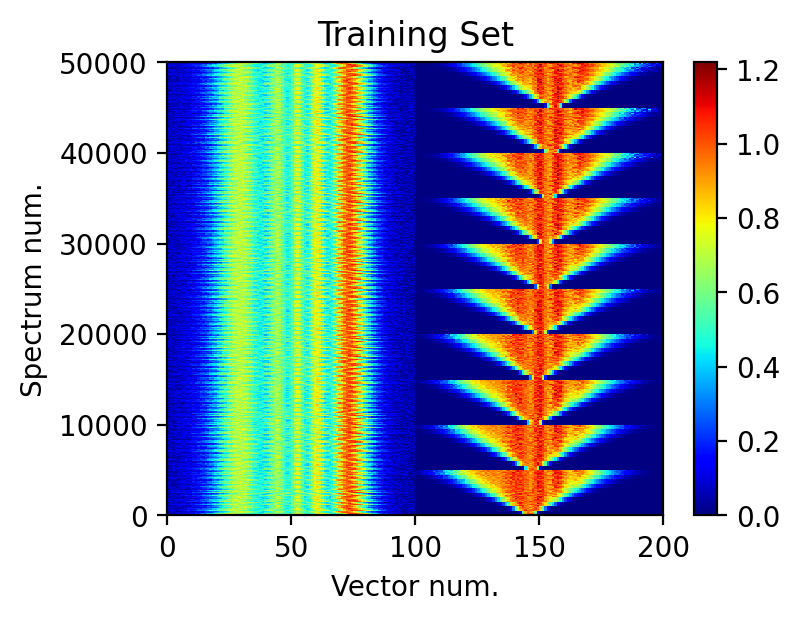

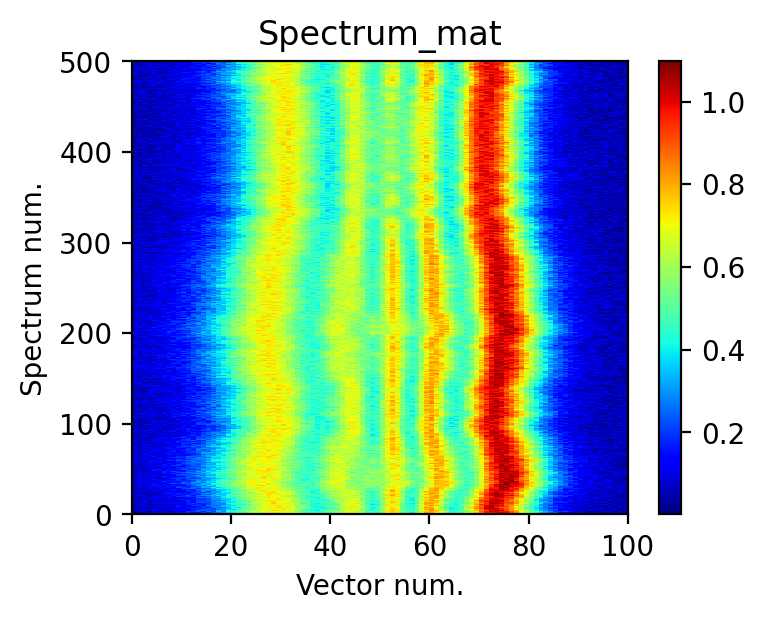

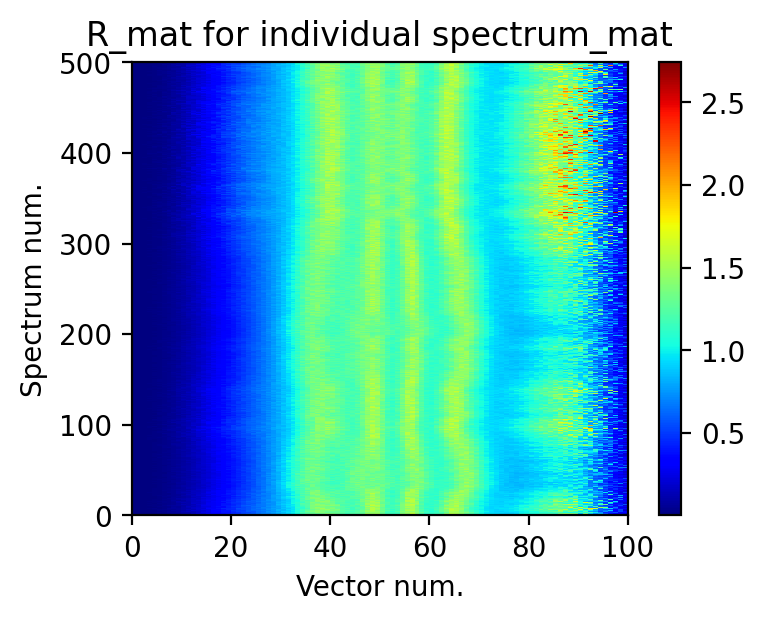

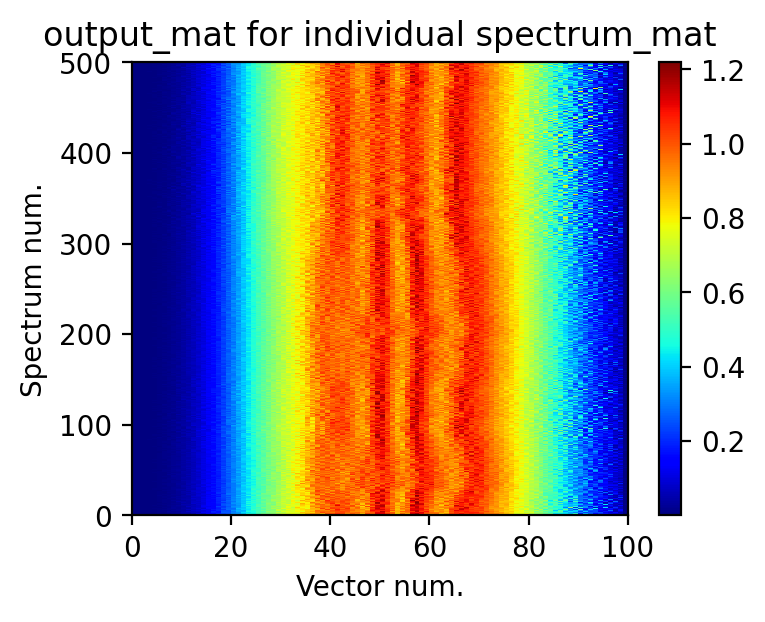

In [32]:
def shift_spectrum(y,step_num):
    # shift spectrum y by step_num, to simulate calibration shift
    if y.ndim == 1:
        y = np.hstack((np.zeros(10)+0.001,y))
        y = np.hstack((y,np.zeros(10)+0.001))
        shift_spec = y[10-step_num:-10-step_num]
    if y.ndim == 2:
        y = np.hstack((np.zeros((y.shape[0],10))+0.001,y))
        y = np.hstack((y,np.zeros((y.shape[0],10))+0.001))
        shift_spec = y[:,10-step_num:-10-step_num]
    return shift_spec

def pulse_shaper(measured_spectrum,mask,shift=-1):
    # simulates pulse shaper transfer function
    output_spectrum = mask*np.sqrt(shift_spectrum(measured_spectrum,shift))
    return output_spectrum

def generate_ideal_mask(measured_spectrum,goal_spectrum,shift=-1):
    # generates the ideal amplitude mask for a measured spectrum and a goal spectrum
    mask = goal_spectrum/np.sqrt(shift_spectrum(measured_spectrum,shift))
    return mask

training_full_set = []
label_full_set = []


width_num = 10
center_num = 10
for center in np.linspace(2.03,2.08,center_num):
    for width in np.linspace(0.01,0.12,width_num):
        # Populating training_full_set and label_full_set
        # 1) spectrum_mat = generated random spectrum sequence
        # 2) goal = desired pulse spectrum, super-Gaussian
        # 3) R_mat = naively calculate amplitude mask that would give you goal spectrum
        # 4) output_mat = calculate the output spectrum resulting from the input spectrum for the naive mask guess
        # Note: output_mat generally does not correspond to the goal spectrum because R_mat is naive and is not equal to ideal mask
        # 5) trainging_full_set = concatenation of spectrum_mat and output_mat
        # 6) label_full_est = R_mat
        # Loop through a variety of goal spectra for every input spectrum
        goal = super_gaus(ev,1,center,width,2)
#             R_mat = generate_ideal_mask(current_spectrum_mat,goal)
        R_mat = goal/np.sqrt(spectrum_mat)   #generate non-ideal mask
        output_mat = pulse_shaper(spectrum_mat,R_mat)
        training_full_set.append(np.hstack((spectrum_mat,output_mat)))
        label_full_set.append(R_mat)   
        
training_full_set = np.array(training_full_set)
training_full_set = np.resize(training_full_set,(spec_num*center_num*width_num,200))
label_full_set = np.array(label_full_set)
label_full_set = np.resize(label_full_set,(spec_num*center_num*width_num,100))

plt.figure(figsize=(4,3),dpi=200)
plt.pcolormesh(training_full_set,cmap="jet")
plt.colorbar()
plt.xlabel("Vector num.")
plt.ylabel("Spectrum num.")
plt.title("Training Set")
# plt.vlines(150,0,70000)
# plt.xlim(1.8,2.3)

plt.figure(figsize=(4,3),dpi=200)
plt.pcolormesh(spectrum_mat,cmap="jet")
plt.colorbar()
plt.xlabel("Vector num.")
plt.ylabel("Spectrum num.")
plt.title("Spectrum_mat")
# plt.xlim(1.8,2.3)

plt.figure(figsize=(4,3),dpi=200)
plt.pcolormesh(R_mat,cmap="jet")
plt.colorbar()
plt.xlabel("Vector num.")
plt.ylabel("Spectrum num.")
plt.title("R_mat for individual spectrum_mat")
# plt.xlim(1.8,2.3)

plt.figure(figsize=(4,3),dpi=200)
plt.pcolormesh(output_mat,cmap="jet")
plt.colorbar()
plt.xlabel("Vector num.")
plt.ylabel("Spectrum num.")
plt.title("output_mat for individual spectrum_mat")
#plt.xlim(1.8,2.3)

# Generate and train model

In [33]:
# Model
# number of input nodes = 2*len(spectrum)
# single hidden layer with 100 nodes
# number of output nodes = len(spectrum)
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam',metrics="accuracy")
    return model

#Shuffle and split training_full_set into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(training_full_set, label_full_set, test_size=0.2, random_state=42)
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
model = get_model(n_inputs, n_outputs)

In [34]:
# fit the model on all data
history = model.fit(X_train, y_train, verbose=2, epochs=100)

Epoch 1/100
1250/1250 - 3s - loss: 0.0130 - accuracy: 0.2997 - 3s/epoch - 2ms/step
Epoch 2/100
1250/1250 - 2s - loss: 0.0018 - accuracy: 0.4308 - 2s/epoch - 2ms/step
Epoch 3/100
1250/1250 - 2s - loss: 0.0013 - accuracy: 0.4899 - 2s/epoch - 2ms/step
Epoch 4/100
1250/1250 - 2s - loss: 0.0011 - accuracy: 0.5335 - 2s/epoch - 2ms/step
Epoch 5/100
1250/1250 - 2s - loss: 8.9892e-04 - accuracy: 0.5681 - 2s/epoch - 2ms/step
Epoch 6/100
1250/1250 - 2s - loss: 7.9549e-04 - accuracy: 0.5984 - 2s/epoch - 2ms/step
Epoch 7/100
1250/1250 - 2s - loss: 7.1450e-04 - accuracy: 0.6291 - 2s/epoch - 2ms/step
Epoch 8/100
1250/1250 - 2s - loss: 6.5146e-04 - accuracy: 0.6585 - 2s/epoch - 2ms/step
Epoch 9/100
1250/1250 - 2s - loss: 6.0242e-04 - accuracy: 0.6746 - 2s/epoch - 2ms/step
Epoch 10/100
1250/1250 - 2s - loss: 5.6555e-04 - accuracy: 0.6946 - 2s/epoch - 2ms/step
Epoch 11/100
1250/1250 - 2s - loss: 5.3786e-04 - accuracy: 0.7028 - 2s/epoch - 2ms/step
Epoch 12/100
1250/1250 - 2s - loss: 5.1274e-04 - accuracy

Epoch 95/100
1250/1250 - 2s - loss: 3.1790e-04 - accuracy: 0.8435 - 2s/epoch - 2ms/step
Epoch 96/100
1250/1250 - 2s - loss: 3.2151e-04 - accuracy: 0.8443 - 2s/epoch - 2ms/step
Epoch 97/100
1250/1250 - 2s - loss: 3.2042e-04 - accuracy: 0.8435 - 2s/epoch - 2ms/step
Epoch 98/100
1250/1250 - 2s - loss: 3.1977e-04 - accuracy: 0.8421 - 2s/epoch - 2ms/step
Epoch 99/100
1250/1250 - 2s - loss: 3.1953e-04 - accuracy: 0.8460 - 2s/epoch - 2ms/step
Epoch 100/100
1250/1250 - 2s - loss: 3.1842e-04 - accuracy: 0.8428 - 2s/epoch - 2ms/step


# Verify Model Convergence

313/313 [==============================] - 0s 1ms/step - loss: 3.3110e-04 - accuracy: 0.8313

Test accuracy: 0.8313000202178955


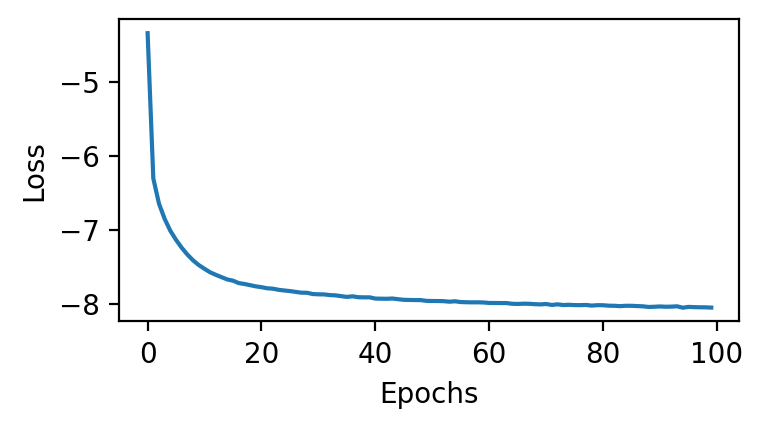

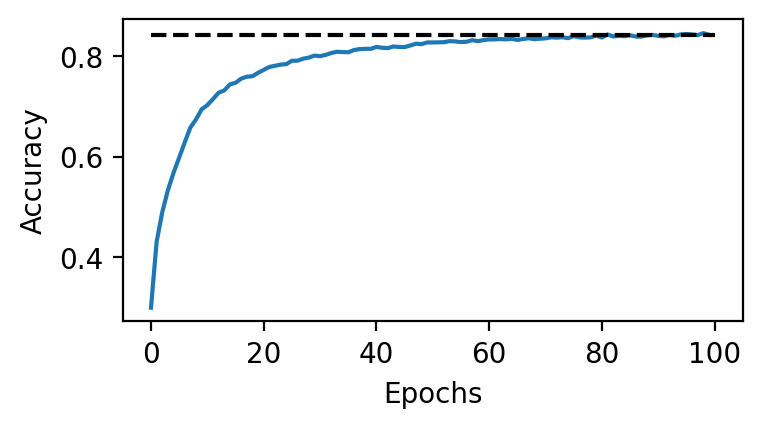

In [36]:
plt.figure(figsize=(4,2),dpi=200)
plt.plot(np.log(history.history['loss']))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.hlines(history.history['loss'][-1],0,len(history.history['loss']),color="k",linestyle="--")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.hlines(history.history['accuracy'][-1],0,len(history.history['accuracy']),color="k",linestyle="--")

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', score[1])

# Validate Model

1/1 [==============================] - 0s 27ms/step


Text(0, 0.5, 'Intensity (a.u.)')

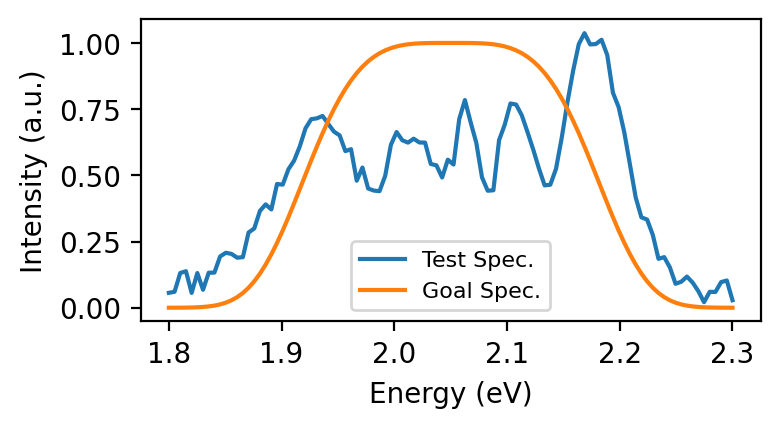

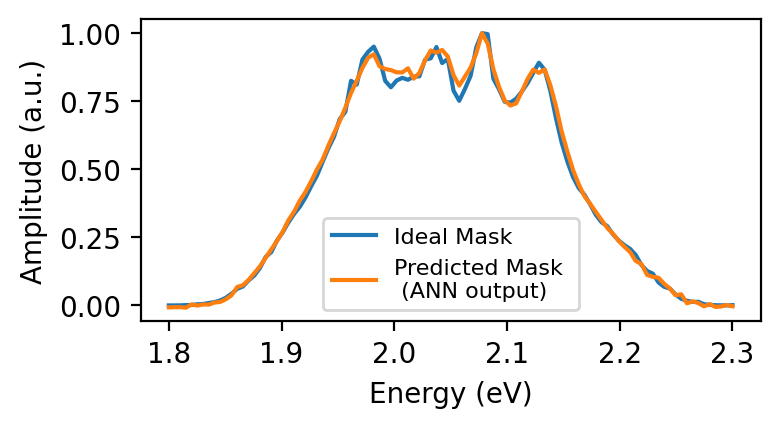

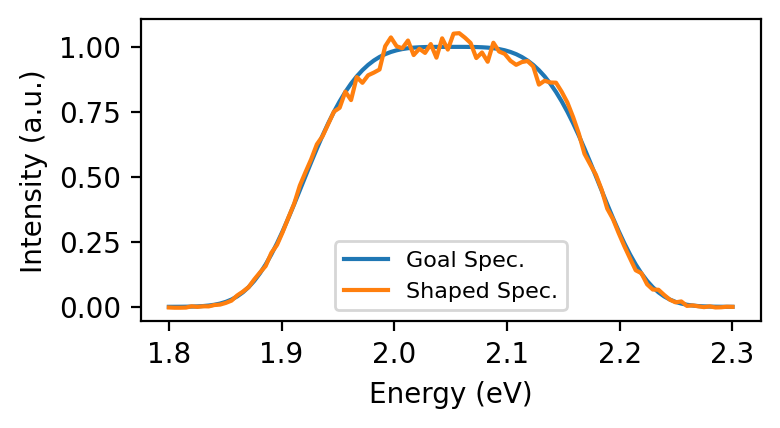

In [45]:
"""
Validate model with test data from earlier partition

1) Take test spectrum
2) Couple with ideal goal spectrum
3) Use model to predict the amplitude mask that would shape the test spectrum into the goal spectrum
4) Compare predicted mask to ideal mask
"""
test_spectrum = X_test[701,0:100] #get just the input spectrum for the test partition
goal_spectrum = super_gaus(ev,1,2.05,0.1,2) #test with an ideal goal spectrum

row = np.hstack((test_spectrum,goal_spectrum))
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)
# print('Predicted: %s' % yhat[0])

plt.figure(figsize=(4,2),dpi=200)
plt.plot(ev,row[0:int(len(row)/2)],label="Test Spec.")
plt.plot(ev,goal_spectrum,label="Goal Spec.")
plt.legend(fontsize=8)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")

plt.figure(figsize=(4,2),dpi=200)
ideal_mask = generate_ideal_mask(test_spectrum,goal_spectrum)
ideal_mask = ideal_mask/np.max(ideal_mask)
plt.plot(ev,ideal_mask,label="Ideal Mask")
plt.plot(ev,yhat[0]/np.max(yhat[0]),label="Predicted Mask \n (ANN output)")
plt.legend(fontsize=8)
plt.xlabel("Energy (eV)")
plt.ylabel("Amplitude (a.u.)")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(ev,goal_spectrum,label="Goal Spec.")
shaped_spec = pulse_shaper(test_spectrum,yhat[0])
# shaped_spec = shaped_spec/np.max(shaped_spec)
plt.plot(ev,shaped_spec,label="Shaped Spec.")
plt.legend(fontsize=8)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (a.u.)")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.13it/s]


Text(0.5, 1.0, 'Shaped Spec. with ANN mask')

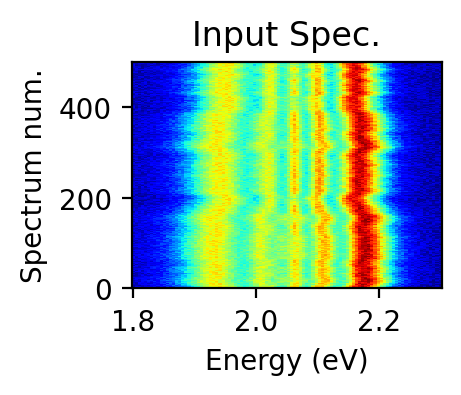

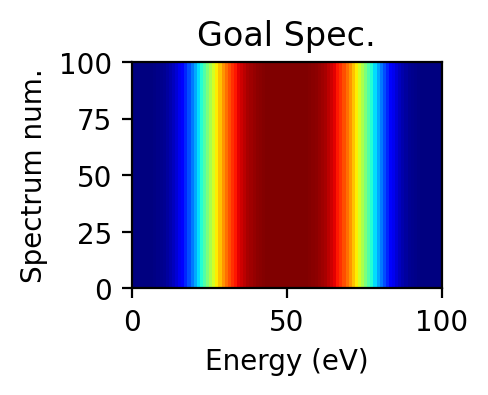

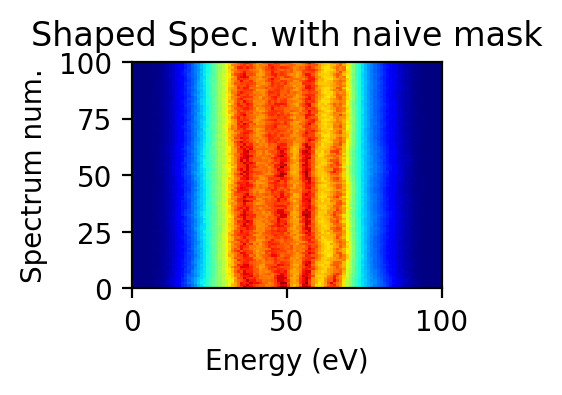

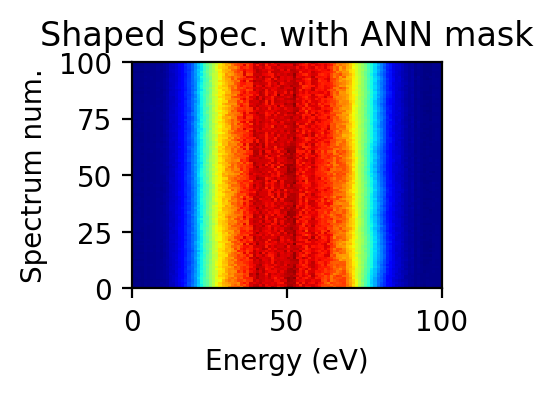

In [49]:
"""
Validate model with separately generated random spectrum sequence

1) Take test spectrum
2) Couple with ideal goal spectrum
3) Use model to predict the amplitude mask that would shape the test spectrum into the goal spectrum
4) Compare predicted mask to ideal mask
"""
test_mat = []
nonideal_mat = []
goal_mat = []
for i in tqdm(range(0,spectrum_mat_test.shape[1])):
    goal_mat.append(goal_spectrum)
    nonideal_mat.append(goal_spectrum/np.sqrt(spectrum_mat_test[i,:]))
        
    row = np.hstack((spectrum_mat_test[i,:],goal_spectrum))
    newX = np.asarray([row])
    newX = tf.convert_to_tensor(newX)
    R = model.predict(newX,verbose=0)   #predict mask 
    test_mat.append(pulse_shaper(spectrum_mat_test[i,:],R[0]))
# test_mat = np.array(test_mat)

seq = np.linspace(0,spectrum_mat_test.shape[0],spectrum_mat_test.shape[0])
plt.figure(figsize=(2,1.5),dpi=200)
plt.pcolormesh(ev,seq,spectrum_mat_test,cmap="jet")
plt.xlabel("Energy (eV)")
plt.ylabel("Spectrum num.")
plt.title("Input Spec.")

plt.figure(figsize=(2,1.5),dpi=200)
plt.pcolormesh(goal_mat,cmap="jet")
plt.xlabel("Energy (eV)")
plt.ylabel("Spectrum num.")
plt.title("Goal Spec.")

plt.figure(figsize=(2,1.5),dpi=200)
plt.pcolormesh(nonideal_mat,cmap="jet")
plt.xlabel("Energy (eV)")
plt.ylabel("Spectrum num.")
plt.title("Shaped Spec. with naive mask")

plt.figure(figsize=(2,1.5),dpi=200)
plt.pcolormesh(test_mat,cmap="jet")
plt.xlabel("Energy (eV)")
plt.ylabel("Spectrum num.")
plt.title("Shaped Spec. with ANN mask")